In [197]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, pipeline,model_selection, feature_selection, utils, linear_model, metrics
import matplotlib.pyplot as plt

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


plt.style.use('fivethirtyeight')

In [3]:
!ls

2018 NBA Hackathon Application - Business Track Prompt.pdf  player_data.csv
business-analytics.ipynb				    test_set.csv
game_data.csv						    training_set.csv


In [6]:
gameData = pd.read_csv('game_data.csv')
playerData = pd.read_csv('player_data.csv')
testData = pd.read_csv('test_set.csv')
trainData = pd.read_csv('training_set.csv')

In [19]:
playerData['asg_flag'] = 1*('East ASG' == playerData.ASG_Team) + 1*('West ASG' == playerData.ASG_Team)

In [24]:
playerData.columns

Index(['Season', 'Game_ID', 'Game_Date', 'Team', 'Person_ID', 'Name',
       'ASG_Team', 'Active_Status', 'Minutes', 'Points', 'Defensive_Rebounds',
       'Offensive_Rebounds', 'Assists', 'Steals', 'Blocks', 'Turnovers',
       'Field_Goals', 'Field_Goals_Attempted', 'Three_Pointers',
       'Three_Pointers_Attempted', 'Free_Throws', 'Free_Throws_Attempted',
       'Personal_Fouls', 'asg_flag'],
      dtype='object')

In [25]:
playerData['total_rebounds'] = playerData['Defensive_Rebounds'] + playerData['Offensive_Rebounds']

In [47]:
sumDf = playerData.groupby('Game_ID')[[
    'asg_flag','Turnovers','Three_Pointers_Attempted','Free_Throws_Attempted','Personal_Fouls'
]].sum().reset_index()
maxDf = playerData.groupby('Game_ID')[[
    'Points','total_rebounds','Assists','Steals','Blocks','Three_Pointers',
]].max().reset_index()
playerDataRollUp = pd.merge(sumDf,maxDf,on='Game_ID')
playerDataRollUp.dropna(inplace=True)

In [38]:
gameData.head()

,Season,Game_ID,Game_Date,Team,Location,Wins_Entering_Gm,Losses_Entering_Gm,Team_Minutes,Final_Score,Lead_Changes,Ties,Largest_Lead,Full_Timeouts,Short_Timeouts,Qtr_4_Score,L2M_Score
0,2016-17,21600001,10/25/2016,CLE,H,0,0,240.0,117.0,1.0,3.0,32.0,4.0,1.0,82.0,113.0
1,2016-17,21600001,10/25/2016,NYK,A,0,0,240.0,88.0,0.0,1.0,4.0,4.0,2.0,64.0,84.0
2,2016-17,21600002,10/25/2016,POR,H,0,0,240.0,113.0,6.0,6.0,13.0,5.0,0.0,77.0,104.0
3,2016-17,21600002,10/25/2016,UTA,A,0,0,240.0,104.0,5.0,1.0,8.0,5.0,2.0,83.0,102.0
4,2016-17,21600003,10/25/2016,GSW,H,0,0,240.0,100.0,1.0,2.0,4.0,3.0,1.0,77.0,100.0


In [85]:
gameData['win_pct'] = gameData['Wins_Entering_Gm'] / (gameData['Wins_Entering_Gm'] + gameData['Losses_Entering_Gm'])
gameData.loc[gameData.win_pct.isna(),'win_pct'] = 0
gameData['Game_Date'] = pd.to_datetime(gameData['Game_Date'],format='%m/%d/%Y')

In [93]:
seasonStart = list(gameData.groupby('Season')['Game_Date'].min())

In [101]:
gameData['season_day'] = 0
gameData.loc[gameData['Season']=='2016-17','season_day'] = (gameData['Game_Date'] - seasonStart[0])/3600/24/1000000000
gameData.loc[gameData['Season']!='2016-17','season_day'] = (gameData['Game_Date'] - seasonStart[1])/3600/24/1000000000

In [102]:
gameData

,Season,Game_ID,Game_Date,Team,Location,Wins_Entering_Gm,Losses_Entering_Gm,Team_Minutes,Final_Score,Lead_Changes,Ties,Largest_Lead,Full_Timeouts,Short_Timeouts,Qtr_4_Score,L2M_Score,win_pct,season_day
0,2016-17,21600001,2016-10-25,CLE,H,0,0,240.0,117.0,1.0,3.0,32.0,4.0,1.0,82.0,113.0,0.000000,0
1,2016-17,21600001,2016-10-25,NYK,A,0,0,240.0,88.0,0.0,1.0,4.0,4.0,2.0,64.0,84.0,0.000000,0
2,2016-17,21600002,2016-10-25,POR,H,0,0,240.0,113.0,6.0,6.0,13.0,5.0,0.0,77.0,104.0,0.000000,0
3,2016-17,21600002,2016-10-25,UTA,A,0,0,240.0,104.0,5.0,1.0,8.0,5.0,2.0,83.0,102.0,0.000000,0
4,2016-17,21600003,2016-10-25,GSW,H,0,0,240.0,100.0,1.0,2.0,4.0,3.0,1.0,77.0,100.0,0.000000,0
5,2016-17,21600003,2016-10-25,SAS,A,0,0,240.0,129.0,1.0,1.0,29.0,5.0,1.0,97.0,122.0,0.000000,0
6,2016-17,21600004,2016-10-26,MIA,A,0,0,240.0,108.0,7.0,6.0,19.0,4.0,1.0,80.0,104.0,0.000000,1
7,2016-17,21600004,2016-10-26,ORL,H,0,0,240.0,96.0,7.0,7.0,7.0,4.0,2.0,69.0,92.0,0.000000,1
8,2016-17,21600005,2016-10-26,DAL,A,0,0,265.0,121.0,2.0,7.0,1.0,7.0,4.0,85.0,110.0,0.000000,1
9,2016-17,21600005,2016-10-26,IND,H,0,0,265.0,130.0,2.0,1.0,14.0,5.0,2.0,94.0,110.0,0.000000,1


In [103]:
gameData.columns

Index(['Season', 'Game_ID', 'Game_Date', 'Team', 'Location',
       'Wins_Entering_Gm', 'Losses_Entering_Gm', 'Team_Minutes', 'Final_Score',
       'Lead_Changes', 'Ties', 'Largest_Lead', 'Full_Timeouts',
       'Short_Timeouts', 'Qtr_4_Score', 'L2M_Score', 'win_pct', 'season_day'],
      dtype='object')

In [111]:
margins = abs(gameData.groupby('Game_ID')[[
    'Final_Score','Qtr_4_Score','L2M_Score','win_pct'
]].diff().reset_index())
sumDf = gameData.groupby('Game_ID')[[
    'Wins_Entering_Gm','Losses_Entering_Gm','Final_Score','Lead_Changes',
    'Ties','Full_Timeouts','Short_Timeouts','Qtr_4_Score','L2M_Score'
]].sum().reset_index()
maxDf = gameData.groupby('Game_ID')[[
    'win_pct','Largest_Lead'
]].max().reset_index()
margins['Game_ID'] = sumDf['Game_ID']
teamDataRollup = pd.merge(sumDf,maxDf,on='Game_ID')
teamDataRollup = pd.merge(teamDataRollup,margins.dropna(),on='Game_ID')
teamDataRollup = pd.merge(gameData[['Game_Date','Team','Game_ID']],teamDataRollup,on='Game_ID')
teamDataRollup.dropna(inplace=True)

In [112]:
for col in teamDataRollup.columns:
    if '_x' in col:
        teamDataRollup.rename(index=str,columns={col:col.replace('_x','_margin')},inplace=True)
    elif '_y' in col:
        teamDataRollup.rename(index=str,columns={col:col.replace('_y','_dif')},inplace=True)

In [113]:
teamDataRollup.drop(axis=0,columns=['index'],inplace=True)

In [129]:
dummies = pd.get_dummies(teamDataRollup['Team'])
dummyCols = list(dummies.columns)

In [135]:
finalDf = pd.merge(teamDataRollup,dummies,left_index=True,right_index=True).copy()
finalDf = pd.merge(finalDf.drop(columns=['Team','Game_Date']),playerDataRollUp,on='Game_ID')
# finalDf['Team'] = 

In [136]:
finalDf = pd.merge(finalDf,playerDataRollUp,on='Game_ID')

In [137]:
gameParticipants = finalDf.groupby('Game_ID')[dummyCols].sum().reset_index()
finalDf = pd.merge(finalDf.drop(columns=dummyCols),gameParticipants,on='Game_ID')

In [138]:
finalDf.drop_duplicates(inplace=True)

In [144]:
summedTrain = trainData.groupby('Game_ID')[['Rounded Viewers']].sum().reset_index()

In [145]:
finalDf = pd.merge(finalDf,summedTrain,on='Game_ID')

In [186]:
select_pipe = pipeline.Pipeline(
    [("select",
      feature_selection.SelectKBest(
          score_func=feature_selection.f_regression, k=3)),
     ("model", linear_model.LinearRegression(normalize=False))])
k_folds = model_selection.KFold(n_splits=10, shuffle=True)

In [187]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    finalDf.drop(columns=['Rounded Viewers','Game_ID']),
    finalDf['Rounded Viewers'],
    test_size=0.33)

Text(0.5,1,'Viewership: Max $r^2$ of 0.6679 with 62 features')

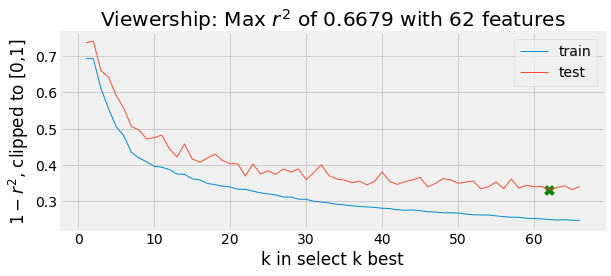

In [191]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(10, 5))
plt.tight_layout(pad=5)
fig.set_facecolor('white')
train_scores=[]
test_scores=[]
theMax = -np.inf
nFeatures=-1
num_fs = range(1, len(X_train.columns), 1)
for i, num_f in enumerate(num_fs):
    models = []
    select_pipe.set_params(select__k=num_f)
    cv_result = model_selection.cross_validate(
        select_pipe, X=X_train, y=y_train, cv=k_folds, return_train_score=True)
    train_scores.append(np.mean(cv_result['train_score']))
    test_scores.append(np.mean(cv_result['test_score']))
    if np.mean(cv_result['test_score']) > theMax:
        theMax = np.mean(cv_result['test_score'])
        nFeatures = num_f
select_pipe.set_params(select__k=nFeatures)
select_pipe.fit(X_train,y_train)
theOrder = np.argsort(select_pipe.named_steps["select"].pvalues_)
theIndex = [theOrder[num] for num in range(nFeatures)]
selectedFeatures = list(np.array(X_train.columns)[theIndex])
select_pipe.fit(X_train[selectedFeatures],y_train)
axes.plot(num_fs, 1 - np.array(train_scores), label="train",linewidth=1)
axes.plot(num_fs, 1 - np.maximum(test_scores, 0), label="test",linewidth=1)
axes.scatter(nFeatures,1 - theMax, s=100,c='green',marker='X')
axes.set_xlabel("k in select k best")
axes.set_ylabel("$1-r^2$, clipped to [0,1]")
axes.legend()
axes.set_title(f'Viewership: Max $r^2$ of {round(theMax,4)} with {nFeatures} features', color='black')

In [192]:
lasso_pipe = pipeline.Pipeline([
    ("imp", preprocessing.Imputer()), 
    ("std", preprocessing.MinMaxScaler()),
    ("model", linear_model.Lasso())
])

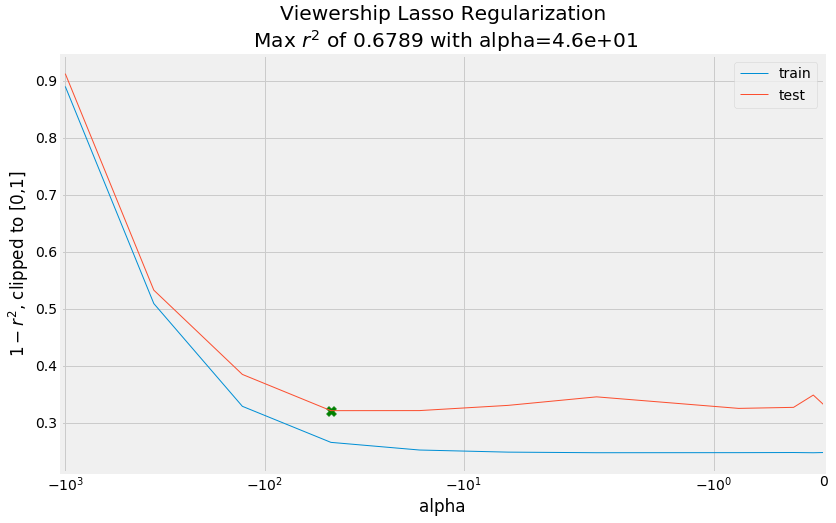

In [212]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(15, 10))
plt.tight_layout(pad=10)
fig.set_facecolor('white')

alphas = list(np.logspace(-1,3,num=10))
alphas.extend([0])
alphas.sort()
alphas = np.array(alphas)
train_scores = []
test_scores = []
theMax=-10
theAlpha = 0
zeroR=0
for alpha in alphas:
    lasso_pipe.set_params(model__alpha=alpha)
    est = linear_model.Lasso(alpha=alpha, normalize=True)
    cv_result = model_selection.cross_validate(
        lasso_pipe, X=X_train, y=y_train, cv=k_folds, return_train_score=True)
    train_scores.append(np.mean(cv_result['train_score']))
    test_scores.append(np.mean(cv_result['test_score']))
    if np.mean(cv_result['test_score']) > theMax:
        theMax = np.mean(cv_result['test_score'])
        theAlpha = alpha
    if alpha==0:
        zeroR = np.mean(cv_result['test_score'])
        
lasso_pipe.set_params(model__alpha=theAlpha)
lasso_pipe.fit(X_train,y_train)

axes.plot(-alphas, 1 - np.array(train_scores), label="train",linewidth=1)
axes.plot(-alphas, 1 - np.maximum(test_scores, 0), label="test",linewidth=1)
axes.scatter(-theAlpha,1 - theMax, s=100,c='green',marker='X')
axes.set_xlabel("alpha")
axes.set_ylabel("$1-r^2$, clipped to [0,1]")
axes.set_xlim(right=0)
axes.legend()
axes.set_title(f'Viewership Lasso Regularization\n Max $r^2$ of {round(theMax,4)} with alpha={theAlpha:.2}' )
axes.set_xscale('symlog')
# axes.set_yticks((0,1))

In [213]:
ridge_pipe = pipeline.Pipeline([
    ("imp", preprocessing.Imputer()), 
    ("std", preprocessing.MinMaxScaler()),
    ("model", linear_model.Ridge())
])

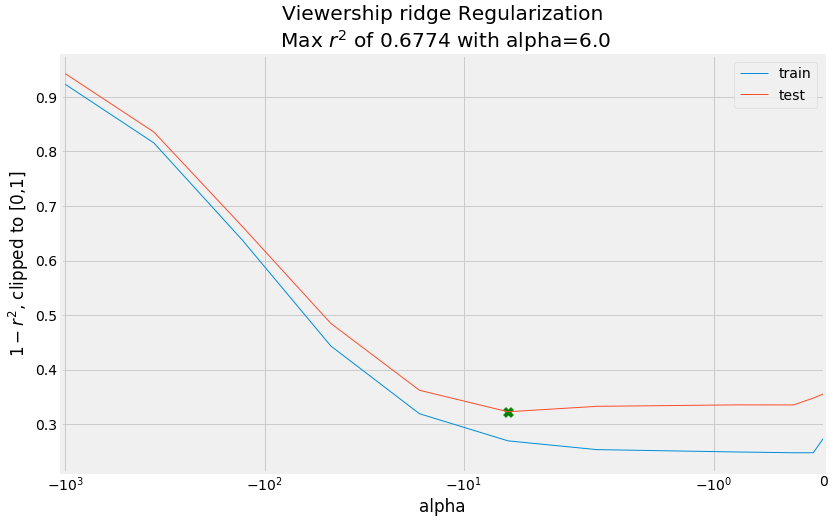

In [215]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(15, 10))
plt.tight_layout(pad=10)
fig.set_facecolor('white')

alphas = list(np.logspace(-1,3,num=10))
alphas.extend([0])
alphas.sort()
alphas = np.array(alphas)
train_scores = []
test_scores = []
theMax=-10
theAlpha = 0
zeroR=0
for alpha in alphas:
    ridge_pipe.set_params(model__alpha=alpha)
    est = linear_model.Ridge(alpha=alpha, normalize=True)
    cv_result = model_selection.cross_validate(
        ridge_pipe, X=X_train, y=y_train, cv=k_folds, return_train_score=True)
    train_scores.append(np.mean(cv_result['train_score']))
    test_scores.append(np.mean(cv_result['test_score']))
    if np.mean(cv_result['test_score']) > theMax:
        theMax = np.mean(cv_result['test_score'])
        theAlpha = alpha
    if alpha==0:
        zeroR = np.mean(cv_result['test_score'])
        
ridge_pipe.set_params(model__alpha=theAlpha)
ridge_pipe.fit(X_train,y_train)

axes.plot(-alphas, 1 - np.array(train_scores), label="train",linewidth=1)
axes.plot(-alphas, 1 - np.maximum(test_scores, 0), label="test",linewidth=1)
axes.scatter(-theAlpha,1 - theMax, s=100,c='green',marker='X')
axes.set_xlabel("alpha")
axes.set_ylabel("$1-r^2$, clipped to [0,1]")
axes.set_xlim(right=0)
axes.legend()
axes.set_title(f'Viewership ridge Regularization\n Max $r^2$ of {round(theMax,4)} with alpha={theAlpha:.2}' )
axes.set_xscale('symlog')
# axes.set_yticks((0,1))